<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-24_21_09_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [16]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [19]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [20]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

In [21]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [22]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [23]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [24]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 10

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [25]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = SGD(model.parameters()) #SGD(model.parameters(), lr=0.01, momentum=0.9)

    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [26]:
model = Module().to(device)

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

Task 0 Start!
Epoch	1	Acc:  0.3216, Loss:  0.0086
Epoch	2	Acc:  0.5952, Loss:  0.0077
Epoch	3	Acc:  0.6840, Loss:  0.0070
Epoch	4	Acc:  0.7270, Loss:  0.0065
Epoch	5	Acc:  0.7519, Loss:  0.0060
Epoch	6	Acc:  0.7679, Loss:  0.0056
Epoch	7	Acc:  0.7790, Loss:  0.0052
Epoch	8	Acc:  0.7895, Loss:  0.0049
Epoch	9	Acc:  0.7972, Loss:  0.0047
Epoch	10	Acc:  0.8034, Loss:  0.0045
Task 0 Acc:  0.8186, Loss:  0.0044
Task 1 Acc:  0.1074, Loss:  0.0096

Task 1 Start!
Epoch	1	Acc:  0.1219, Loss:  0.0091
Epoch	2	Acc:  0.1488, Loss:  0.0088
Epoch	3	Acc:  0.1740, Loss:  0.0087
Epoch	4	Acc:  0.1963, Loss:  0.0086
Epoch	5	Acc:  0.2178, Loss:  0.0085
Epoch	6	Acc:  0.2379, Loss:  0.0084
Epoch	7	Acc:  0.2545, Loss:  0.0083
Epoch	8	Acc:  0.2706, Loss:  0.0083
Epoch	9	Acc:  0.2847, Loss:  0.0082
Epoch	10	Acc:  0.2982, Loss:  0.0081
Task 0 Acc:  0.8026, Loss:  0.0044
Task 1 Acc:  0.3034, Loss:  0.0079



 - Task 0

Accuracy 0.8026
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.82      0.95      0.88       980
     1 - one       0.89      0.92      0.90      1135
     2 - two       0.72      0.80      0.76      1032
   3 - three       0.66      0.89      0.76      1010
    4 - four       0.84      0.80      0.82       982
    5 - five       0.91      0.44      0.59       892
     6 - six       0.82      0.83      0.82       958
   7 - seven       0.87      0.84      0.86      1028
   8 - eight       0.80      0.73      0.76       974
    9 - nine       0.80      0.77      0.78      1009

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.79     10000
weighted avg       0.81      0.80      0.80     10000



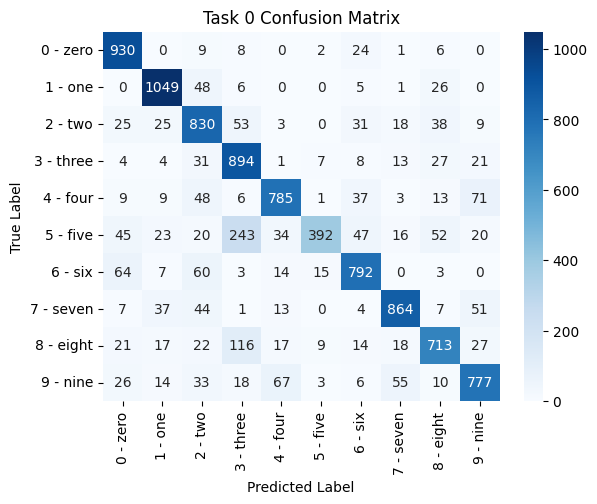

In [27]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.3034
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.41      0.77      0.53       980
     1 - one       0.00      0.00      0.00      1135
     2 - two       0.30      0.29      0.30      1032
   3 - three       0.25      0.21      0.23      1010
    4 - four       0.14      0.18      0.16       982
    5 - five       0.07      0.03      0.04       892
     6 - six       0.36      0.33      0.34       958
   7 - seven       0.32      0.49      0.39      1028
   8 - eight       0.45      0.50      0.48       974
    9 - nine       0.30      0.25      0.27      1009

    accuracy                           0.30     10000
   macro avg       0.26      0.31      0.27     10000
weighted avg       0.26      0.30      0.27     10000



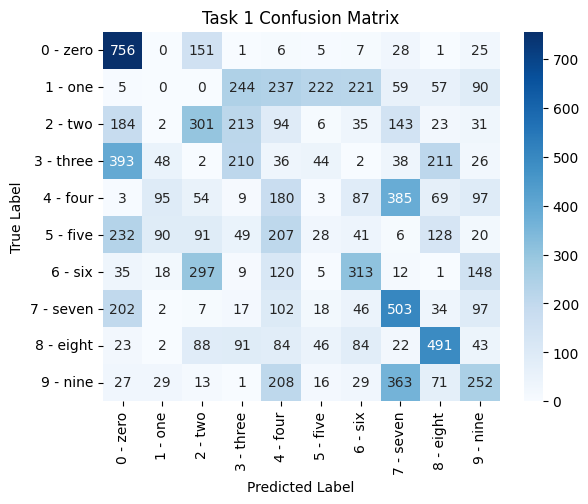

In [28]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.1.weight
torch.Size([10, 784])
Max fisher is 8.89279 and it's parameter diff is 0.00013
Min Parameter diff is 0.10234 and it's fisher is 0.00129
fisher > parameter diff: 486
fisher <= parameter diff: 298


<Figure size 640x480 with 0 Axes>

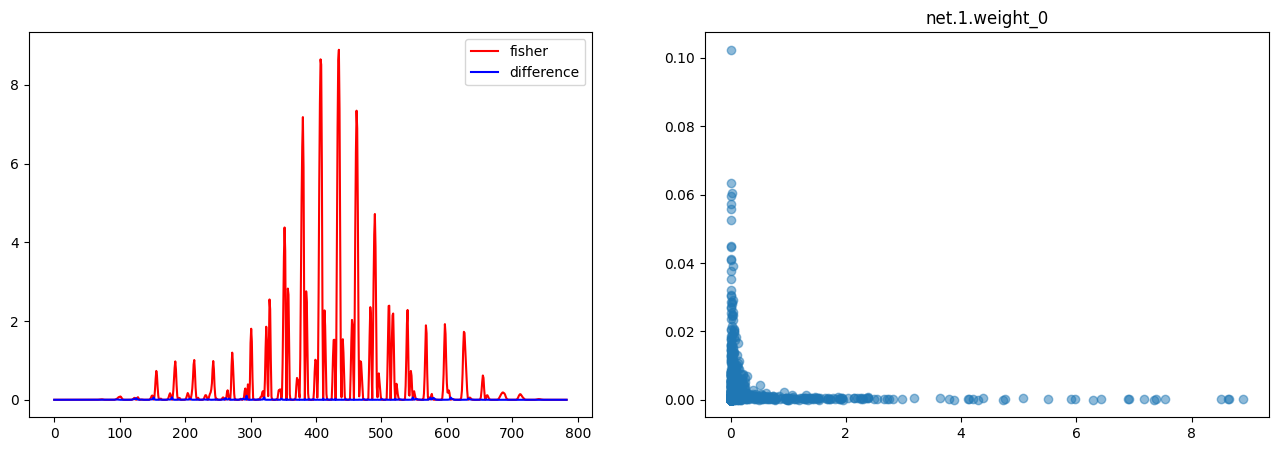

Max fisher is 18.98872 and it's parameter diff is 0.00014
Min Parameter diff is 0.05081 and it's fisher is 0.00143
fisher > parameter diff: 507
fisher <= parameter diff: 277


<Figure size 640x480 with 0 Axes>

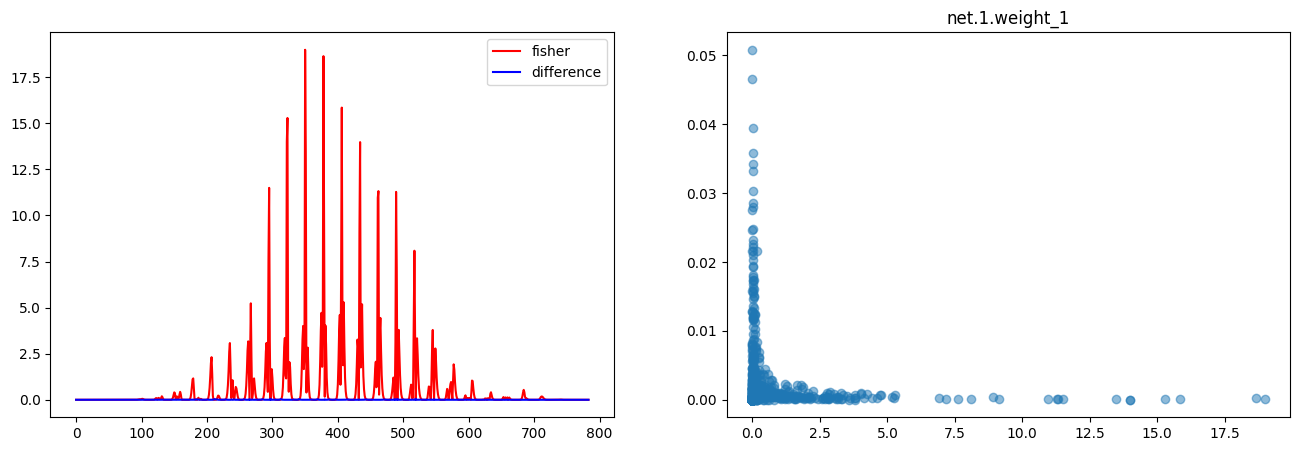

Max fisher is 6.52601 and it's parameter diff is 0.00002
Min Parameter diff is 0.06153 and it's fisher is 0.00108
fisher > parameter diff: 504
fisher <= parameter diff: 280


<Figure size 640x480 with 0 Axes>

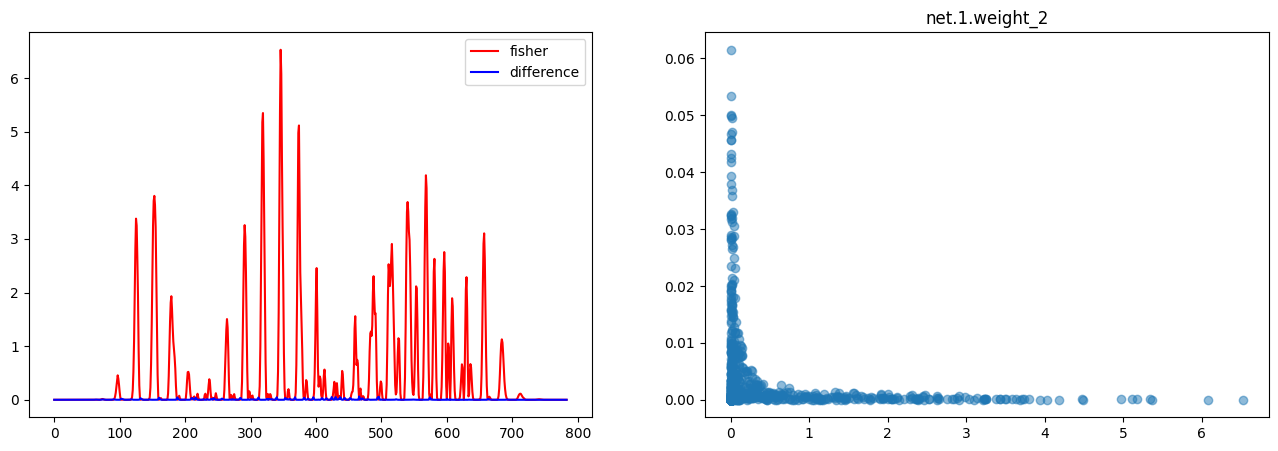

Max fisher is 5.81369 and it's parameter diff is 0.00023
Min Parameter diff is 0.07132 and it's fisher is 0.00052
fisher > parameter diff: 497
fisher <= parameter diff: 287


<Figure size 640x480 with 0 Axes>

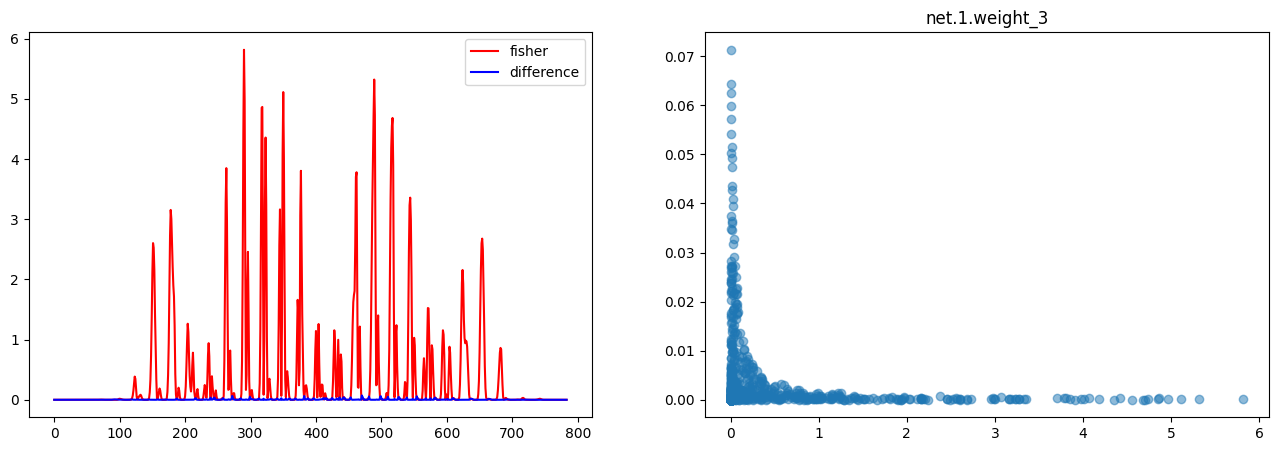

Max fisher is 9.37796 and it's parameter diff is 0.00008
Min Parameter diff is 0.08499 and it's fisher is 0.00068
fisher > parameter diff: 466
fisher <= parameter diff: 318


<Figure size 640x480 with 0 Axes>

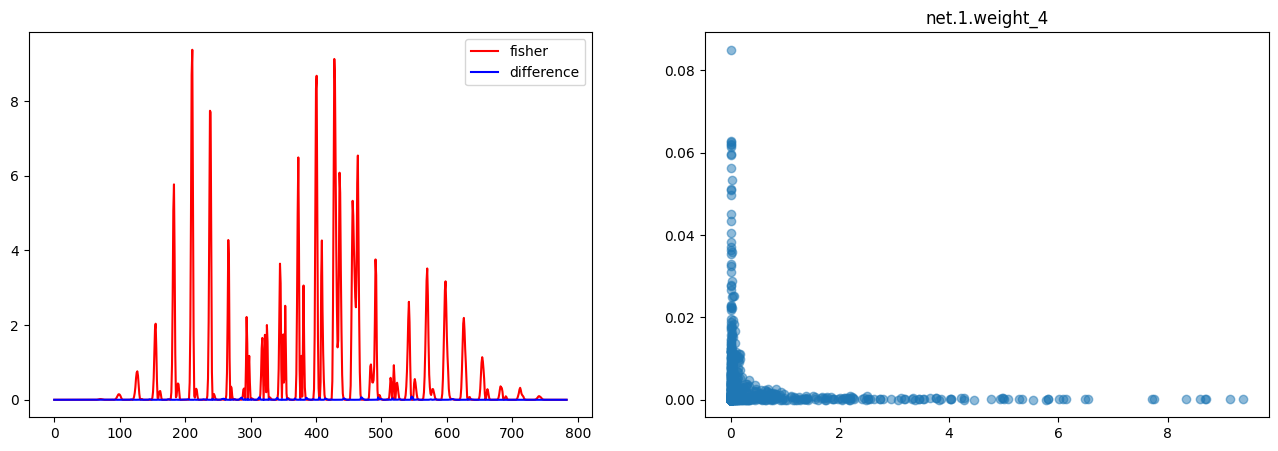

Max fisher is 8.08772 and it's parameter diff is 0.00010
Min Parameter diff is 0.05371 and it's fisher is 0.00489
fisher > parameter diff: 489
fisher <= parameter diff: 295


<Figure size 640x480 with 0 Axes>

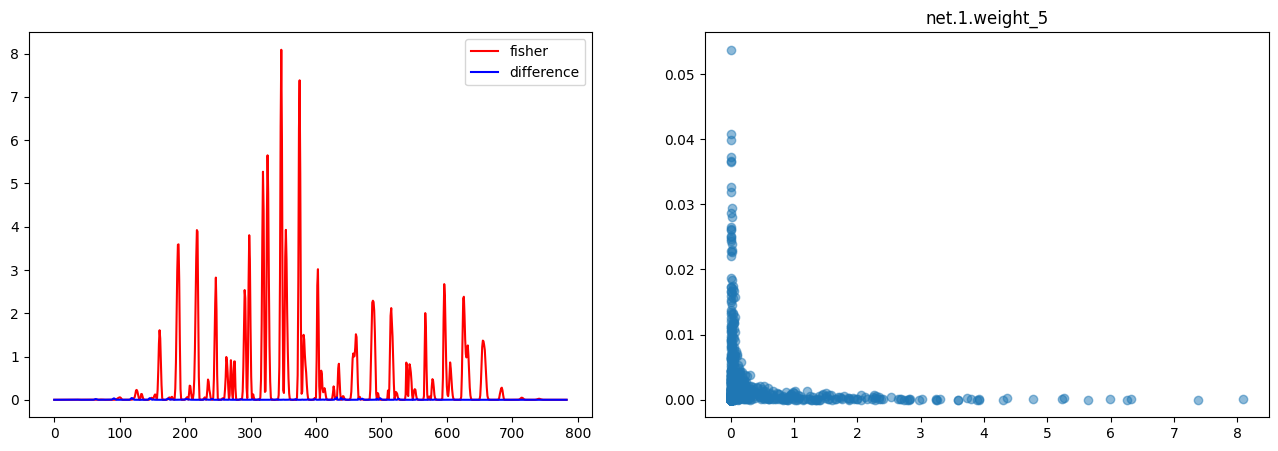

Max fisher is 9.75816 and it's parameter diff is 0.00005
Min Parameter diff is 0.07475 and it's fisher is 0.00077
fisher > parameter diff: 520
fisher <= parameter diff: 264


<Figure size 640x480 with 0 Axes>

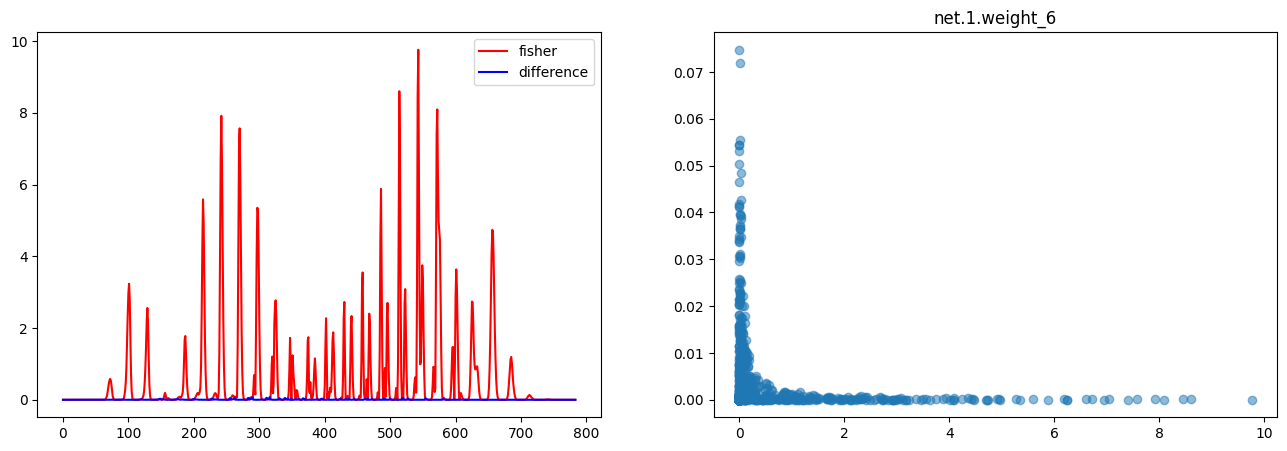

Max fisher is 8.75231 and it's parameter diff is 0.00013
Min Parameter diff is 0.05758 and it's fisher is 0.00543
fisher > parameter diff: 519
fisher <= parameter diff: 265


<Figure size 640x480 with 0 Axes>

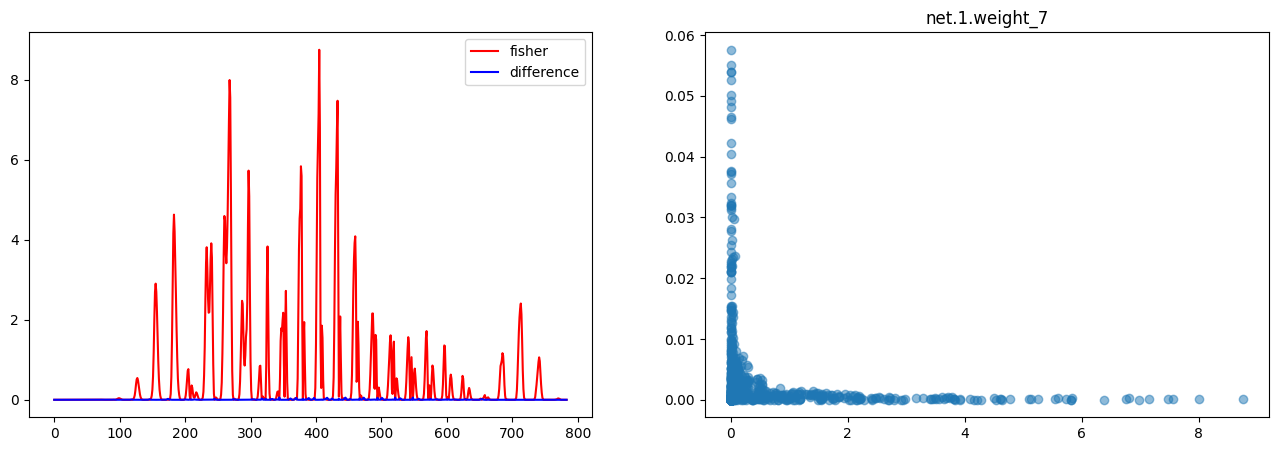

Max fisher is 5.05013 and it's parameter diff is 0.00001
Min Parameter diff is 0.04199 and it's fisher is 0.00042
fisher > parameter diff: 496
fisher <= parameter diff: 288


<Figure size 640x480 with 0 Axes>

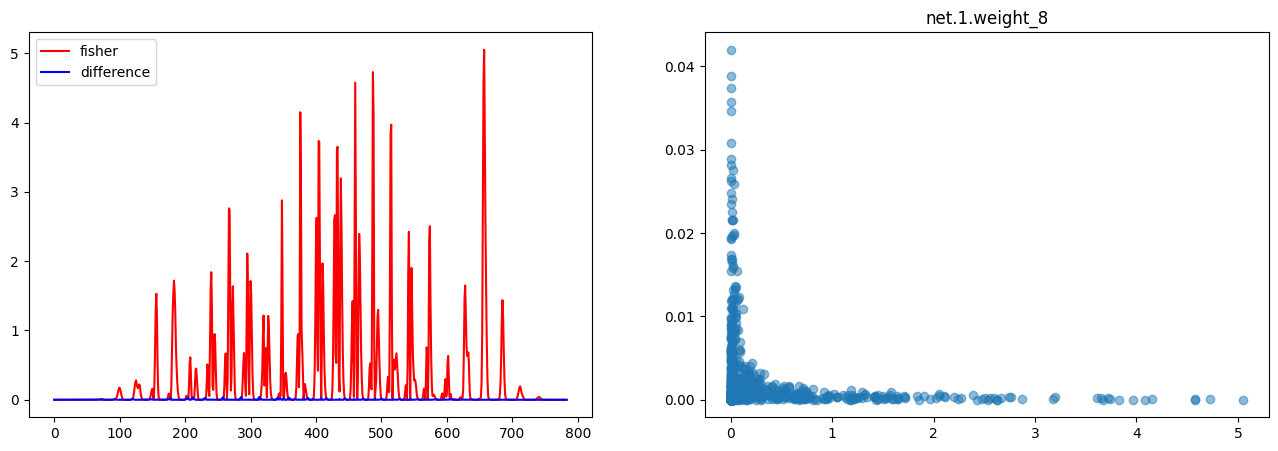

Max fisher is 8.94042 and it's parameter diff is 0.00007
Min Parameter diff is 0.05548 and it's fisher is 0.00973
fisher > parameter diff: 503
fisher <= parameter diff: 281


<Figure size 640x480 with 0 Axes>

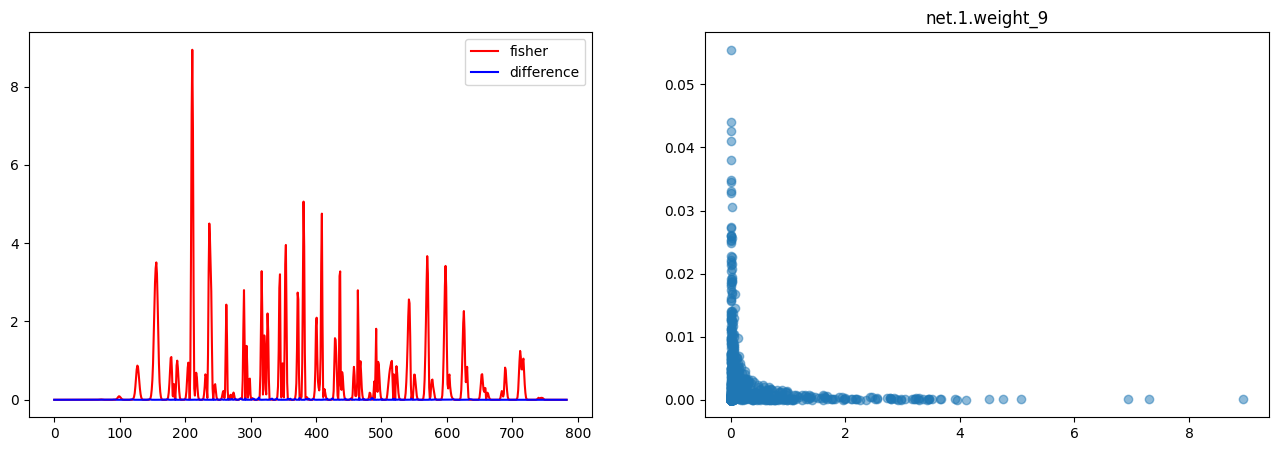


net.1.bias
torch.Size([10])
Max fisher is 3.72172 and it's parameter diff is 0.00074
Min Parameter diff is 0.01428 and it's fisher is 0.02637
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

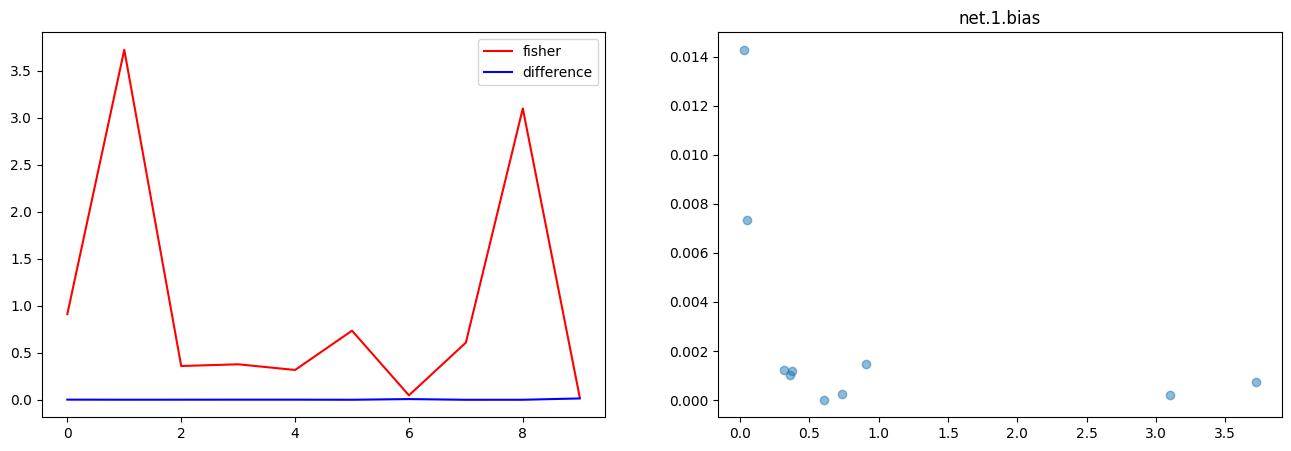

In [29]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i], optim_para[0][name][i], param[i], f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [30]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-24_21_09_06
